In [28]:
import cv2
import numpy as np
import tensorflow as tf
from tqdm import tqdm 
import os  

In [29]:
path = "C:/Users/ajite/Desktop/kaggle/Dog vs Cats/"
learning_rate= 1e-3
model_name = 'dogvscat-{}_model'.format('covolutional')

In [39]:

IMG_SIZE=50    
def create_data(path, train_or_test):
    def label_image(img):
        img_label= img.split('.')[-3]
        if img_label== 'cat': return [1,0]
        elif img_label== 'dog': return [0,1]
        
    if train_or_test=='train':
        train_data=[]
        traning_path= path +'train'
        for i in tqdm(os.listdir(traning_path)):
            label=label_image(i)
            path_img=os.path.join(traning_path,i)
            image= cv2.imread(path_img, cv2.IMREAD_GRAYSCALE)
            image= cv2.resize(image, (IMG_SIZE,IMG_SIZE))
            train_data.append([np.array(image), np.array(label)])
        np.save('train_data.npy', train_data)
        return train_data
    elif train_or_test== 'test':
        test_data=[]
        test_path= path +'test1'
        for i in tqdm(os.listdir(test_path)):
            path_img=os.path.join(test_path,i)
            image_number= i.split('.')[0]
            image= cv2.imread(path_img, cv2.IMREAD_GRAYSCALE)
            image= cv2.resize(image, (IMG_SIZE,IMG_SIZE))
            test_data.append([np.array(image), image_number])
        np.save('test_data.npy', test)        
        return test_data


In [31]:
train_data = create_data(path, 'train')
#train_data = np.load('test_data.npy')

100%|██████████| 25000/25000 [01:01<00:00, 408.21it/s]


In [32]:
import tensorflow as tf
tf.compat.v1.reset_default_graph()

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
convnet_input = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

conv1 = conv_2d(convnet_input, 32, 5, activation='relu')
maxpool1 = max_pool_2d(conv1, 5)

conv2 = conv_2d(maxpool1, 64, 5, activation='relu')
maxpool2 = max_pool_2d(conv2, 5)

conv3 = conv_2d(maxpool2, 128, 5, activation='relu')
maxpool3 = max_pool_2d(conv3, 5)

conv4 = conv_2d(maxpool3, 256, 5, activation='relu')
maxpool4 = max_pool_2d(conv4, 5)

conv5 = conv_2d(maxpool4, 128, 5, activation='relu')
maxpool5 = max_pool_2d(conv5, 5)

conv6 = conv_2d(maxpool5, 64, 5, activation='relu')
maxpool6 = max_pool_2d(conv6, 5)

conv7 = conv_2d(maxpool6, 32, 5, activation='relu')
maxpool7 = max_pool_2d(conv7, 5)

fully_connected1 = fully_connected(maxpool7, 1024, activation='relu')
dropout1 = dropout(fully_connected1, 0.8)

fully_connected2= fully_connected(dropout1, 2, activation='softmax')
convnet = regression(fully_connected2, optimizer='adam', learning_rate=learning_rate, loss='categorical_crossentropy', name='output')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [33]:
if os.path.exists('{}.meta'.format(model_name)):
    model.load(model_name)
    print('model loaded!')

In [34]:
from random import shuffle
shuffle(train_data)
train = train_data[:-500]
validation  = train_data[-500:]
train_x = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE,IMG_SIZE,1)
train_y = [i[1] for i in train]
validation_x = np.array([i[0] for i in validation]).reshape(-1, IMG_SIZE,IMG_SIZE,1)
validation_y = [i[1] for i in validation]



In [35]:
model.fit({'input': train_x }, {'output': train_y }, n_epoch=10, validation_set=({'input': validation_x}, {'output': validation_y}), 
    snapshot_step=500, show_metric=True, run_id=model_name)

Training Step: 3829  | total loss: 0.28987 | time: 108.427s
| Adam | epoch: 010 | loss: 0.28987 - acc: 0.8858 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.29638 | time: 109.709s
| Adam | epoch: 010 | loss: 0.29638 - acc: 0.8800 | val_loss: 0.47978 - val_acc: 0.8140 -- iter: 24500/24500
--


In [36]:
model.save(model_name)

INFO:tensorflow:C:\Users\ajite\Desktop\kaggle\Dog vs Cats\dogvscat-covolutional_model is not in all_model_checkpoint_paths. Manually adding it.


In [37]:
if os.path.exists('{}.meta'.format(model_name)):
    model.load(model_name)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from C:\Users\ajite\Desktop\kaggle\Dog vs Cats\dogvscat-covolutional_model
model loaded!


In [40]:
test_data = create_data(path, 'test')

100%|██████████| 12500/12500 [01:20<00:00, 155.06it/s]


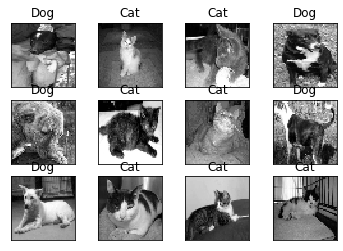

In [44]:
import matplotlib.pyplot as plt

fig=plt.figure()

for num,data in enumerate(test_data[:12]):

    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [45]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))    


100%|██████████| 12500/12500 [01:00<00:00, 206.07it/s]
